# **Time Series Homework 2**

Edward Anderson

**Honor Pledge**: On my honor as a student, I have neither given nor received any unauthorized aid on this assignment. - Edward Anderson

In [20]:
# Libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

## **QUESTION 1: Show a data description.**
1. Provide a summary of the data set to include descriptive statistics.
2. Plot the time series.
3. (optional) Provide any additional plots that may show important characteristics of your data

In [21]:
# Load & Preprocess Data
sales = pd.read_csv('data/sales_data.csv')
sales['date'] = pd.to_datetime(sales['date'], errors='coerce')
sales['qty'] = pd.to_numeric(sales['qty'], errors='coerce')
sales['val'] = pd.to_numeric(sales['val'], errors='coerce')
# Subset and Group
sales = sales[~sales['world'].isin(['gr', 'na'])]
sales = sales.groupby('date').sum().reset_index().drop(columns=['world'])
sales.sort_values('date', inplace=True)
# Correct sales anaomaly
sales.rename(columns={'qty' : 'order_quantity', 'val' : 'order_value'}, inplace=True)
sales.loc[sales['order_quantity'].idxmax(), 'order_quantity'] = sales.loc[sales['order_quantity'].idxmax() - 1, 'order_quantity']
sales.loc[sales['order_value'].idxmax(), 'order_value'] = sales.loc[sales['order_value'].idxmax() - 1, 'order_value']
# Group by Week
sales['date'] = sales['date'].dt.to_period('W').apply(lambda r: r.start_time)
sales = sales.groupby('date').sum().reset_index()
print(sales.head())

        date  order_quantity  order_value
0 2018-01-01           474.0    1147036.0
1 2018-01-08           492.0    1153592.0
2 2018-01-15           852.0    2301456.0
3 2018-01-22           756.0    1933800.0
4 2018-01-29           822.0    2020556.0


In [22]:
# Descriptive Stats and EDA
print("Basic Descriptive Statistics:")
sales.describe().style.format("{:,.0f}", subset=['order_quantity', 'order_value'])

Basic Descriptive Statistics:


,date,order_quantity,order_value
count,419,419,419
mean,2022-01-09 04:21:11.599045,"2,914","6,472,871"
min,2018-01-01 00:00:00,474,"1,147,036"
25%,2020-01-02 12:00:00,"1,530","3,588,158"
50%,2022-01-10 00:00:00,"2,508","5,871,536"
75%,2024-01-18 12:00:00,"3,783","8,573,088"
max,2026-01-19 00:00:00,"16,116","21,200,652"
std,nan,"2,007","3,732,091"


The table above shows the descriptive stats of these data. For this assignment, I will be modeling order quantity. These data are weekly, so the date represents the first day of each week. The mean order quantity is ~2900 units, the max is ~16,000, and the minimum is 474. These data are highly variable with a standard deviation of ~2,000 units. Finally, we have plenty of data points (419 weeks) which is enough to detect patterns, trends, and seasonality in the data. 

In [23]:
# Plot Sales Qty Over Time
plot = px.line(sales, x='date', y='order_quantity', 
               hover_data=['order_quantity'], 
               labels={'order_quantity':'Sales Quantity', 
                       'date':'Date'})
plot.update_layout(title='Sales Over Time')
plot.show()

# Plot Sales Value
plot = px.line(sales, x='date', y='order_value', 
               hover_data=['order_value'], 
               labels={'order_value':'Sales Value', 
                       'date':'Date'})
plot.update_layout(title='Sales Value Over Time')
plot.show()

In [24]:
# FUCNTIONS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def diagnostic_plot(series, title="Time Series"):
    '''Plot Time Series, ACF, PACF, and Histogram for a given series.'''
    plt.style.use('ggplot')
    fig, ax = plt.subplots(2,2, figsize=(15,10))
    fig.suptitle(f'Diagnostic Plots: {title}', fontsize=16, fontweight='bold')
    # Time series plot
    ax[0,0].plot(series, linewidth=1.5, color='darkblue')
    ax[0,0].set_title('Original Time Series', fontweight='bold')
    ax[0,0].set_xlabel('Time')
    ax[0,0].set_ylabel('Value')
    ax[0,0].grid(True, alpha=0.3)
    # ACF plot
    plot_acf(series, lags=min(60, len(series)//2), ax=ax[0,1], alpha=0.05)
    ax[0,1].set_title('Autocorrelation Function (ACF)', fontweight='bold')
    # PACF plot
    plot_pacf(series, lags=min(60, len(series)//2), ax=ax[1, 0], 
              alpha=0.05, method='ywm')
    ax[1, 0].set_title('Partial Autocorrelation Function (PACF)', fontweight='bold')
    
    # Histogram
    ax[1, 1].hist(series, bins=30, density=True, alpha=0.7, 
                    color='darkblue', edgecolor='black')
    ax[1, 1].set_title('Distribution', fontweight='bold')
    ax[1, 1].set_xlabel('Value')
    ax[1, 1].set_ylabel('Density')
    ax[1, 1].grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

from statsmodels.tsa.stattools import adfuller, kpss
def adf_test(series):
    '''Function to perform ADF test on series and print results.'''
    result = adfuller(series)
    print("ADF TEST RESULTS:")
    print('   ADF Statistic: {:.4f}'.format(result[0]))
    print('   p-value: {:.4f}'.format(result[1]))
    if result[1] < 0.05:
        print("Conclusion: Reject Null Hypothesis -- Series is Stationary")
    else:
        print("Conclusion: Fail to Reject Null Hypothesis -- Series is Non-Stationary")
def kpss_test(series):
    '''function to perform KPSS test on series and print results...'''
    result = kpss(series)
    print("KPSS TEST RESULTS:")
    print('   KPSS Statistic: {:.4f}'.format(result[0]))
    print('   p-value: {:.4f}'.format(result[1]))
    if result[1] < 0.05:
        print("   Conclusion: Reject Null Hypothesis -- Series is Non-Stationary")
    else:
        print("   Conclusion: Fail to Reject Null Hypothesis -- Series is Stationary")
        
from statsmodels.stats.diagnostic import acorr_ljungbox
def ljung_box_test(series, lags=10):
    '''function to perform LB test on series and print results'''
    result = acorr_ljungbox(series, lags=lags, return_df=True)
    print("Ljung-Box Test Results: PVal < .05 means we reject the null and there IS autocorrelation in the data")
    return result.style.format("{:.5f}", subset=['lb_stat', 'lb_pvalue'])

from statsmodels.tsa.seasonal import STL
def stl_decomposition(series, series_name, period):
    '''function to perform STL decompose and plot results'''
    stl = STL(series, period=period)
    result = stl.fit()
    fig = result.plot()
    fig.suptitle(f'STL Decomposition of {series_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

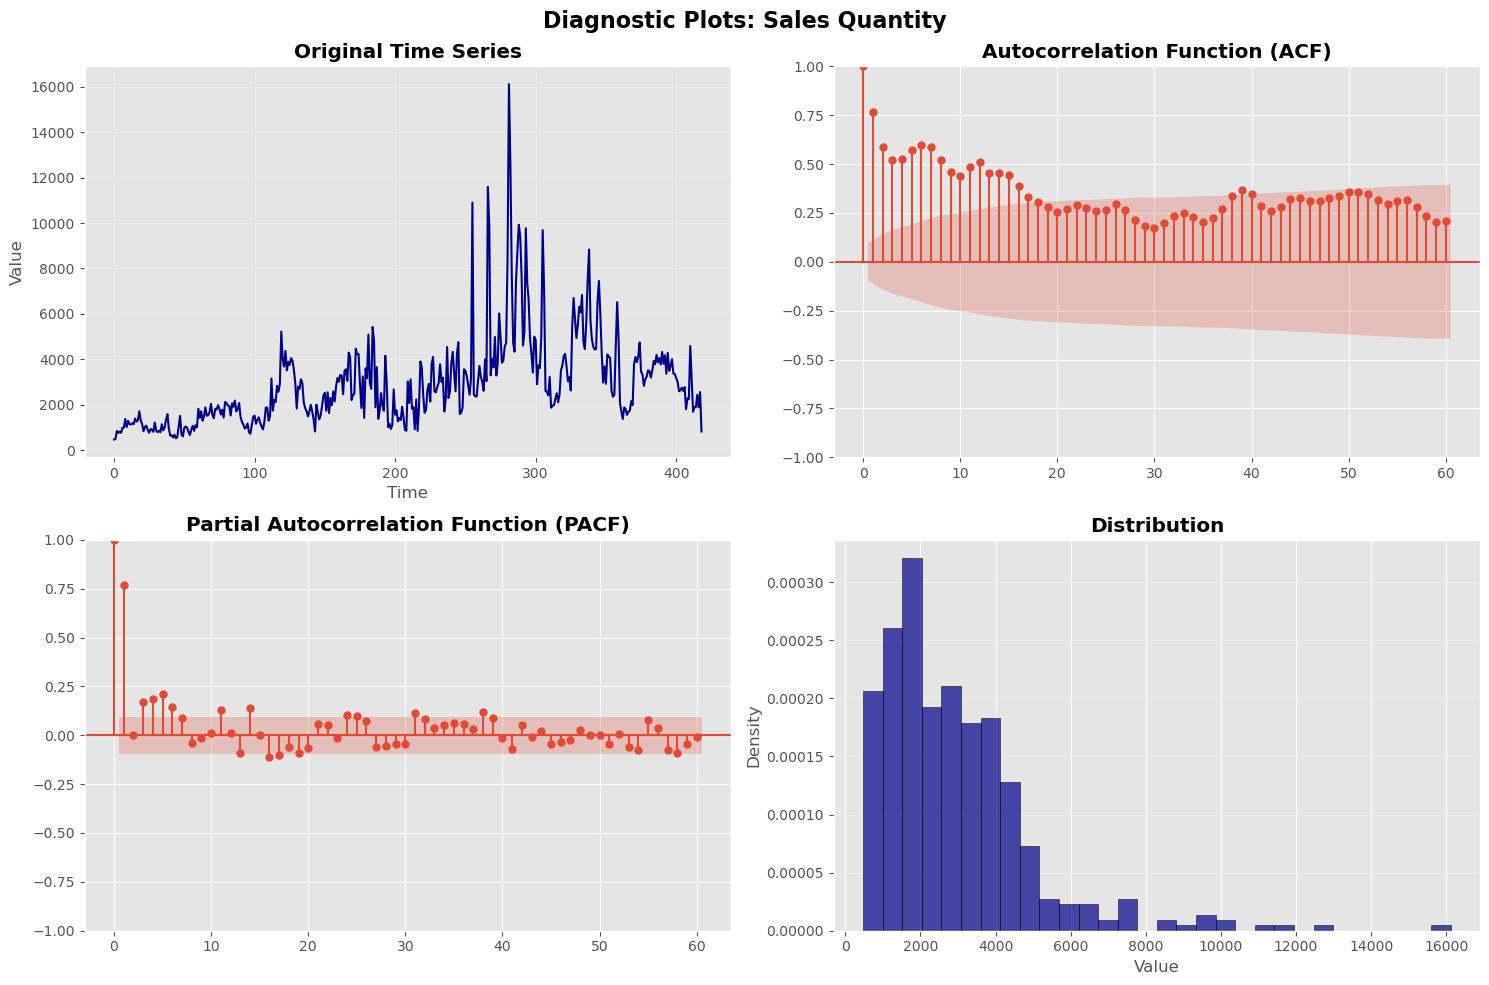

In [25]:
# Plot Diagnostic Plots -- SALES QUANTITY
diagnostic_plot(sales['order_quantity'], title='Sales Quantity')

The autocorrelation plot slowly decreases, which is a sign of non stationarity. The PACF shows a significant spike at lag 1 and then quickly drops off, which suggests that AR(1) *could* be appropriate for this data. Before we do any modeling, however, I need to ensure that the data is stationary (and I don't believe it is given the ACF plot...).

---

## **QUESTION 2**: (45 points): Apply Box Jenkins Methodology using ARIMA, SARIMA, or SARIMAX depending on your data to obtain and evaluate forecasts. 
1. *Identification*: Perform all the necessary steps for identification and include automatic and manual identification. Summarize the results from your identification process. 
2. *Estimation*: Perform all necessary steps for identification and summarize the results of your estimation process.
3. *Diagnostic Checking*: Perform all necessary steps for diagnostic checking and summarize the results of your diagnostic checking process.
4. *Forecasting*: Compare the performance of the forecasts of your selected models using the appropriate methods on a test data set. Show graphics of the forecast performance to include confidence intervals. Describe your results and conclusions about the usefulness of the models you evaluated to forecast in the application domain of the data set.

### **Part 1: Identification**

To identify the appropriate model(s) (and AR / MA orders), I will use ACF / PACF plots, the ADF test, the KPSS test, and the auto_arima function. 

ACF / PACF Plots for Sales Quantity: (SAME AS ABOVE)


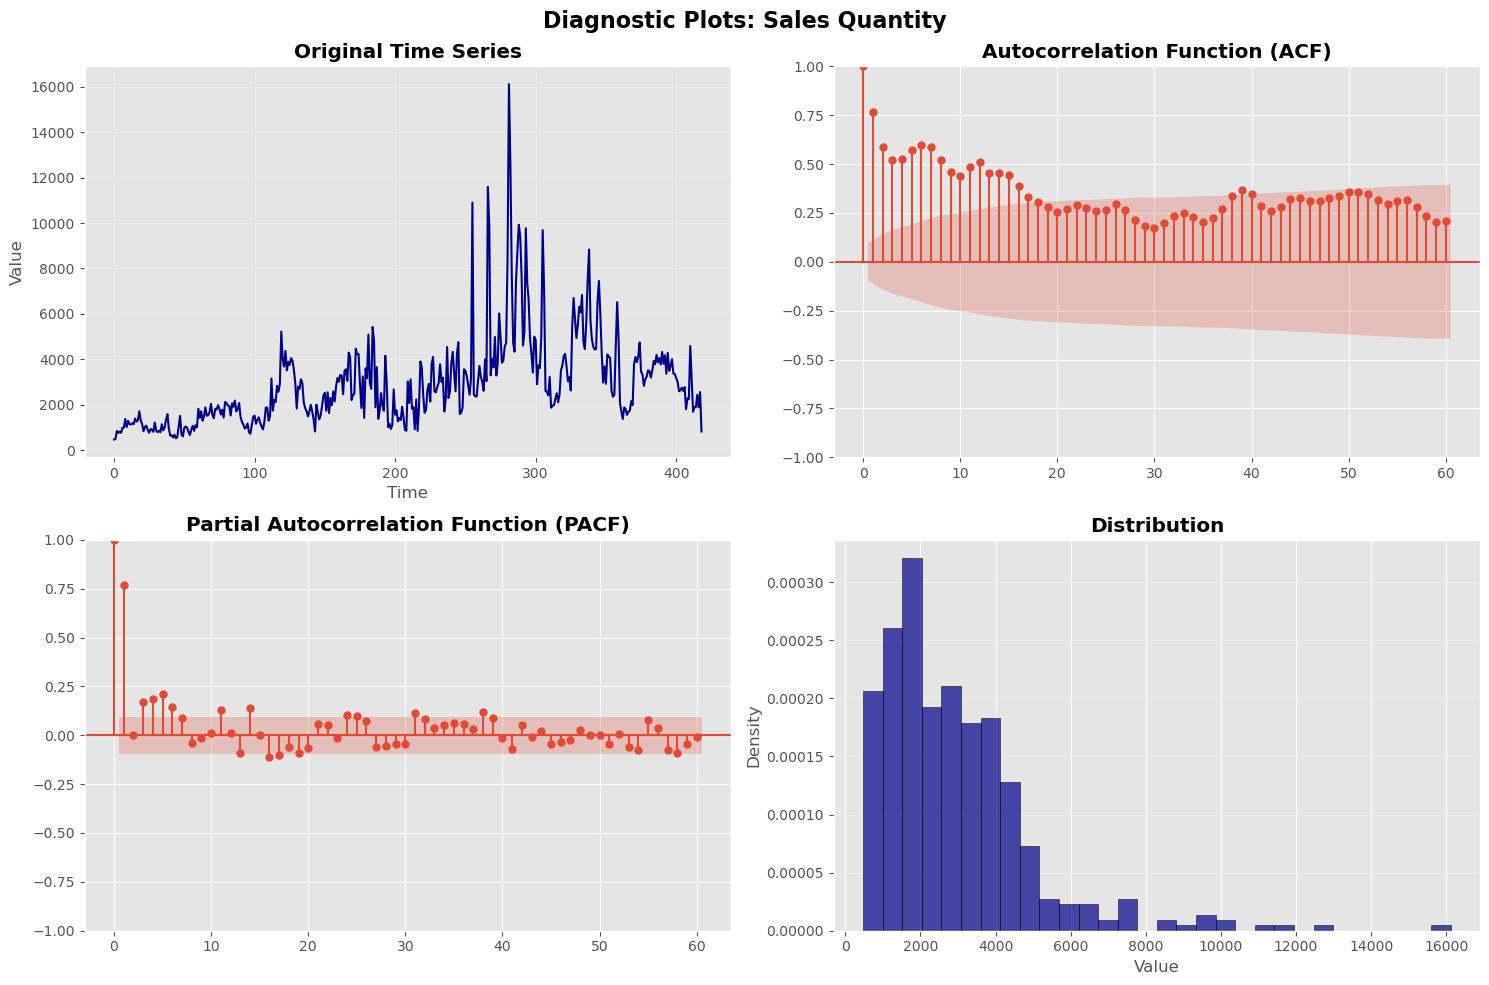

In [26]:
# Plot Diagnostics
print("ACF / PACF Plots for Sales Quantity: (SAME AS ABOVE)")
diagnostic_plot(sales['order_quantity'], title='Sales Quantity')

Based on the ACF plot, there is a slow decay of autocorrelations at lags 1-60, which is a strong sign of non-stationarity. The PACF plot shows a significant spike at lag 1 and then quickly drops off; however, some of the lags after lag 1 are also significant. The spike at lag 1 suggests that AR(1) could be appropriate for the data. The data likely needs to be differenced, so I will assess the PACF and ACF plots after differencing to determine the appropriate AR and MA orders.

In [27]:
adf_test(sales['order_quantity']); print("\n")
kpss_test(sales['order_quantity'])

ADF TEST RESULTS:
   ADF Statistic: -2.9045
   p-value: 0.0448
Conclusion: Reject Null Hypothesis -- Series is Stationary


KPSS TEST RESULTS:
   KPSS Statistic: 1.7403
   p-value: 0.0100
   Conclusion: Reject Null Hypothesis -- Series is Non-Stationary


/tmp/ipykernel_26873/1655461131.py:45: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The ADF test and KPSS test conflict with each other. They both reject the null hypothesis. For ADF, this teams that the data are stationary, but for the KPSS test, this means that the data are nonstationary. The P-Value for the ADF test is close to .05, however, so it barely rejects the null hypothesis. Given the ACF plot, I do not believe these data to be stationary, so I will difference the data, and then reassess these diagnostics.  

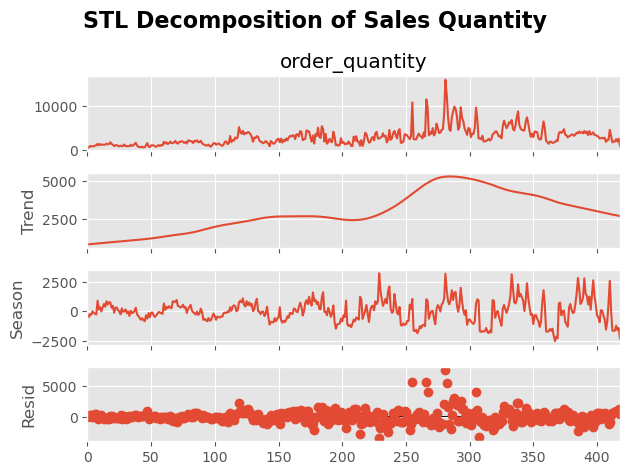

In [30]:
stl_decomposition(sales['order_quantity'], series_name='Sales Quantity', period=52)

In [31]:
ljung_box_test(sales['order_quantity'], lags=10)

Ljung-Box Test Results: PVal < .05 means we reject the null and there IS autocorrelation in the data


,lb_stat,lb_pvalue
1,248.53162,0.00000
2,395.08742,0.00000
3,510.51378,0.00000
4,628.72311,0.00000
5,767.97796,0.00000
6,920.86418,0.00000
7,1068.34003,0.00000
8,1184.34350,0.00000
9,1275.31068,0.00000
10,1358.79844,0.00000


In [ ]:
# First Difference
sales['order_quantity_diff'] = sales['order_quantity'].diff()